<a href="https://colab.research.google.com/github/Cl8D/SSUML/blob/main/Project%203%20-%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
!pip install --upgrade torchtext
!pip freeze | grep torch
import torch
import torchtext

     |████████████████████████████████| 7.0MB 9.9MB/s 
     |████████████████████████████████| 776.8MB 17kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


torch==1.7.1
torchsummary==1.5.1
torchtext==0.8.1
torchvision==0.8.1+cu101


# **Model Architecture**

In [3]:
# 인코더디코더 클래스 정의

class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """

    #각종 변수들 초기화 과정
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

        #src,tgt, 마스크들
        #src = source
        #tgt = target
    
    #마스킹된 source/target 시퀀스 처리 (변수 초기화)
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        #"마스크 처리된 src 및 대상 시퀀스를 가져와서 처리하십시오."

        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    #encode 및 decode 정의
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
#제네레이터 클래스 정의 - 소프트맥스 생성단계 정의 아래 그대로
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
     #"표준 선형 + 소프트맥스 생성 단계를 정의합니다."
     # linear, softmax 정의하기

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

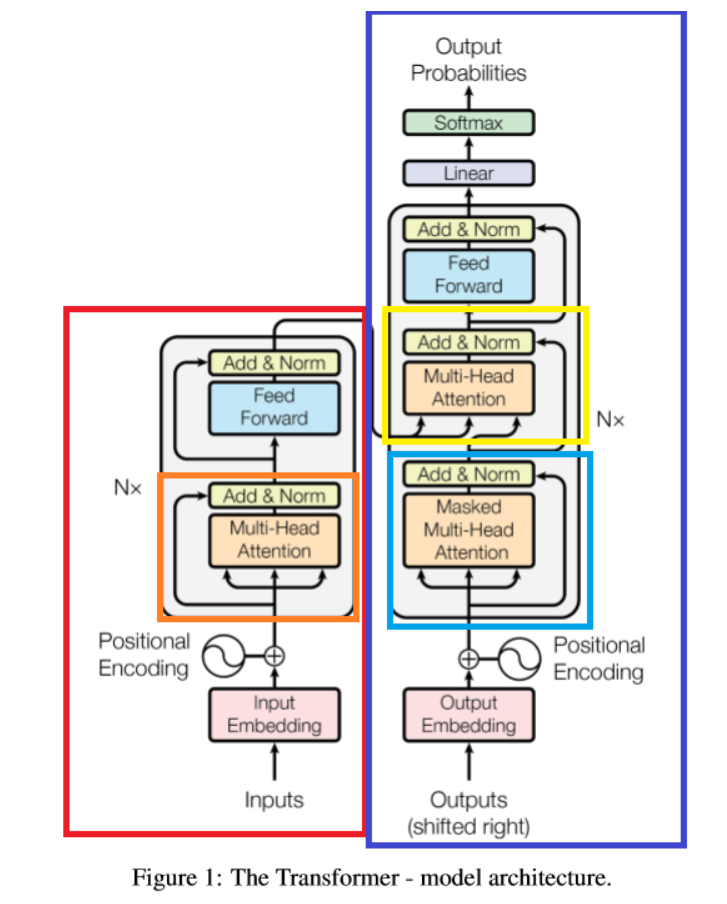

위 그림에서 빨간색이 인코더, 파란색이 디코더를 가르키고, 자세한 설명은 다음과 같습니다.

주황색 : 인코더에서 Self-Attention이 일어나는 부분

하늘색 : 디코더에서 Self-Attention이 일어나는 부분

노란색 : 인코더와 디코더의 Attention이 일어나는 부분

Transformer가 학습하는 전반적인 그림은 다음과 같습니다.

출처: https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225

# **Encoder and Decoder Stacks**

# **Encoder**

In [5]:
# encoder, decoder의 레이어 개수
def clones(module, N):
    "Produce N identical layers."
    #"N개의 동일한 레이어를 생성합니다."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
# ★Encoder class 정의하기@@@@

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    #encoder는 n개의 레이어 층으로 구성되어 있습니다.
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) # 레이어 개수 n개
        self.norm = LayerNorm(layer.size) #layer normalization
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        #각각의 입력 레이어와 마스크를 차례로 통과시킵니다."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

'''
입력에 대한 Position 값을 구합니다. (줄: 14~16)
Input Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)
입력에 대한 attention pad mask를 구합니다. (줄: 22)
for 루프를 돌며 각 layer를 실행합니다. (줄: 27)
layer의 입력은 이전 layer의 출력 값 입니다.
'''

'\n입력에 대한 Position 값을 구합니다. (줄: 14~16)\nInput Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)\n입력에 대한 attention pad mask를 구합니다. (줄: 22)\nfor 루프를 돌며 각 layer를 실행합니다. (줄: 27)\nlayer의 입력은 이전 layer의 출력 값 입니다.\n'

In [7]:
#layer normalization -> residual-connection을 적용하였다.
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    #"레이어 노름 모듈을 구성합니다(자세한 내용은 인용 참조)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) #평균
        std = x.std(-1, keepdim=True) #표준편차
        # Layernorm(x+ sublayer(x)) 형태.
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 #normalization 해주는 식

In [8]:
#sub-layer 부분.
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    """
    나머지 연결 다음에 계층 표준이 나옵니다.
    코드 단순성에 대한 주의는 표준이 맨 먼저 마지막이 아니라 표준입니다.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        #동일한 크기로 sublayer에다가 residual connection을 적용한다.
         #normalization 전에 dropout을 먼저 적용시켜준다.
        return x + self.dropout(sublayer(self.norm(x)))

In [9]:
#인코더 층
#각각의 layer는 2개의 sub-layer를 가지고 있다.
#하나는 multi-head attention, 하나는 position-wise fully-connected feed-forward network.

class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    #"인코더는 자체 어택과 피드포워드(아래 정의)로 구성됩니다."
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        #"연결은 그림 1(왼쪽)에 따릅니다."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

'''
Encoder Layer
Encoder에서 루프를 돌며 처리 할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행 합니다.

Multi-Head Attention을 수행합니다. (줄: 14)
Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.
1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 15)
2번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 17)
3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 18)
'''

'\nEncoder Layer\nEncoder에서 루프를 돌며 처리 할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행 합니다.\n\nMulti-Head Attention을 수행합니다. (줄: 14)\nQ, K, V 모두 동일한 값을 사용하는 self-attention 입니다.\n1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 15)\n2번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 17)\n3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 18)\n'

# **Decoder**

In [10]:
# ★Decoder class 정의하기@@@@
#decoder 역시 6개의 동일한 layer 묶음으로 구성되어 있다.
#디코더는 인코더와 동일하지만, Self-Attention시 Masked-Multi-Head Attention을 쓴다는 점이 다릅니다. 
#Masked를 쓰는 이유는 Self-Attention시 자신의 time step 이후 word는 가려 Self-Attention 되는 것을 막는 역할을 합니다. 

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    #"마스킹 기능이 있는 일반 N 레이어 디코더입니다."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [11]:
#디코더 층
#decoder의 경우 하나의 sub-layer가 더 추가된다.
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    #"디코더는 자체애턴, src-attn 및 피드포워드(아래 정의)로 제작됩니다."
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        #"연결은 그림 1(오른쪽)을 따릅니다."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) #self-attention
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) #self-attention
        return self.sublayer[2](x, self.feed_forward) #feed forward

In [12]:
import numpy as np
from torch.autograd import Variable

#다음 번 위치 mask
def subsequent_mask(size):
    "Mask out subsequent positions."
    #"다음 위치를 마스크합니다."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') #상삼각행렬 형태로
    return torch.from_numpy(subsequent_mask) == 0


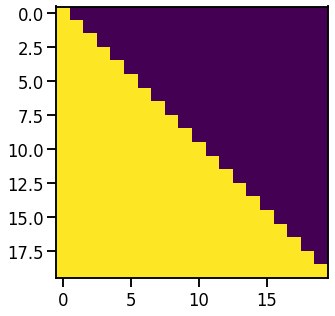

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

# **Attention**

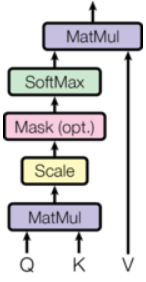

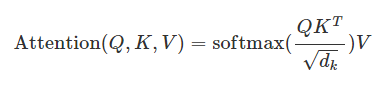

In [14]:
# ★어텐션 함수 정의하기@@@@@@@@중요@@@@@@@@@@ 위의 식 중요하게 작용함.
#Scaled Dot Product라는 의미는 Q와 K 사이를 내적하여 어텐션을 Softmax를 통해 구하고, 
#그 후에 V를 내적하여 중요한 부분(Attention)을 더 살린다는 메커니즘이 내포되어있습니다.

#attention => query와 key-value쌍의 관계를 output으로 mapping해주는 작업.
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) #query, key의 차원 크기
    #위에 있는 수식 그대로 쓴 코드
    #scores = torch.matmul(query, key.transpose(-2, -1) / math.sqrt(d_k)
    scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        #scores.masked_fill_(mask, -1e9)
        scores = scores.masked_fill(mask == 0, -1e9) #mask에 아무것도 없으면 0으로 채워준다.
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn) #dropout이 안 되어있으면 dropout 시켜주기
    return torch.matmul(p_attn, value), p_attn #최종적으로 value 값에 점곱을 해주면서 scaling 마무리

어텐션 메커니즘은 자연어 기계 번역을 위한 Seq2Seq 모델에 처음 도입되었습니다. 어텐션 메커니즘은 NLP 태스크 뿐만 아니라, 도메인에 관계 없이 다양하게 쓰이고 있습니다. 현재의 SOTA NLP모델들은 대부분 어텐션 메커니즘을 적용하고 있으니 최근 논문을 이해함에 있어 이해하고 넘어가야 하는 부분입니다.

https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225

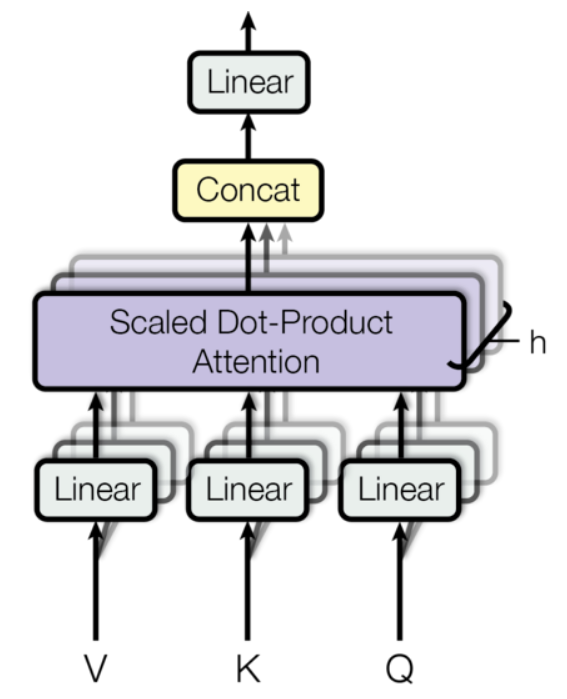

In [15]:
# Multi-Head Attention의 역할은 1문장을 여러 head로 Self-Attention 시킴에 있습니다.
#linear projection을 h번 한 다음 나온 결과값으로부터 attention을계산한다.

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        # d_v 가 항상 d_k와 같을것이라고 가정한다.
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            # 같은 mask를 h개의 head에 적용한다.
            mask = mask.unsqueeze(1) #unsqueeze는 axis 값에 해당하는 차원을 제거하는 용도인 듯
        nbatches = query.size(0) #query size
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        # d_model (h x d_k)에서 모든 linear projection을 일괄적으로 진행한다.
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch.
        # batch에 있는 모든 projected 된 벡터들을 attention에 적용하기 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        # view를 이용하여 concat 하고 (pytorch의 view를 사용하면 tensor의 크기/모양 변경이 가능하다.)

        # transpose 적용시 원래의 tensor와 메모리를 공유하고 있게 되는데, 
        # contiguous는 tensor의 복사본을 만들기 때문에 원래의 텐서와 transpose된 텐서를 함께 가질 수 있도록 하는 것 같다.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# **Position-wise Feed-Forward Networks**

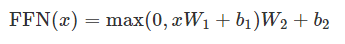

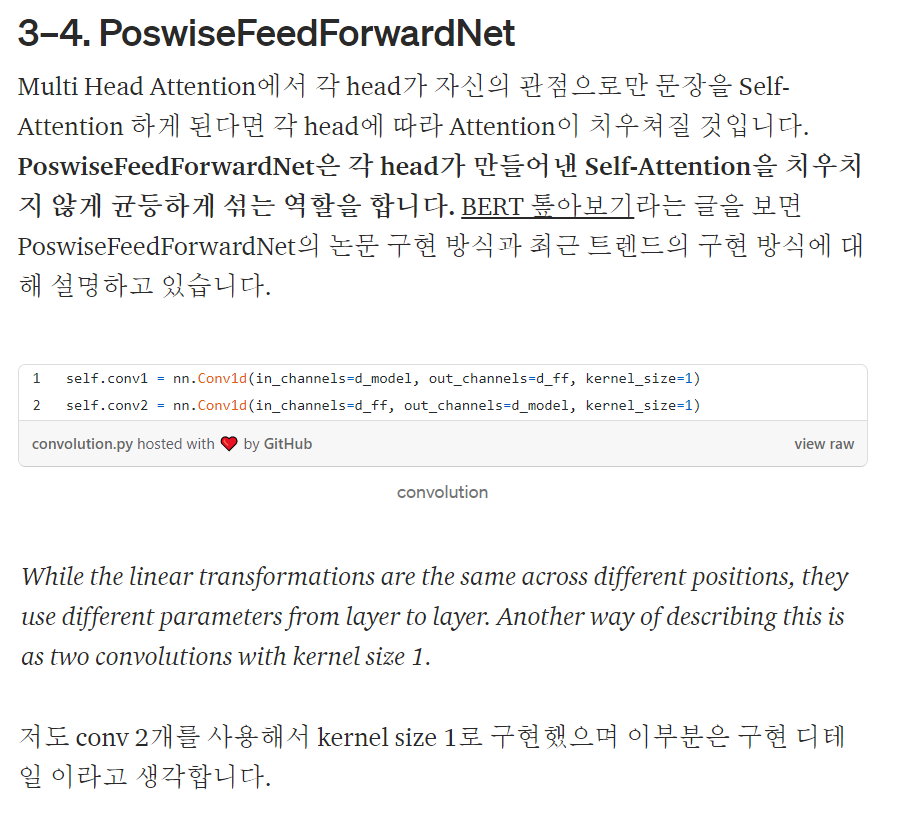

In [16]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        # 여기서 d_model은 512으로 입/출력 레이어의 치수이고
        # d_ff는 내부 레이어의 치수로 2048이다.
        super(PositionwiseFeedForward, self).__init__()
        # pytorch의 linear 함수는 입력 데이터를 linear transformation 해준다.
        # y= xA^T + b 형태로 해준다고 한다...
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #아까와 마찬가지로 linear transformation 하기 전에(여기서 activation 함수로 relu가 적용되었다)
        #dropout을 적용해 준다.
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# **Embeddings and Softmax**

In [17]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # 학습된 embedding을 사용하여 입/출력 토큰을 차원 벡터인 d_model로 변환해 준다.
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # 아마 다음 토큰의 확률로 변환하는 식인 것 같다...
        return self.lut(x) * math.sqrt(self.d_model)

# **Positional Encoding**

In [18]:
# Positional Encoding 이라는 주기함수에 의한 위치에 따른 다른 임베딩을 거치면 같은 단어여도 문장에서 쓰인 위치에 따라 다른 임베딩 값을 가지게 됩니다.
# Positional Encoding은 get_sinusoid_encoding_table이라는 주기 함수로 구현됩니다.

# position에 대한 정보를 받기 위해서 만들어짐. d_model과 같은 차원을 가진다.

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        # PE 식 그대로 써둔 코드.-> sin, cos 사용.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # variable은 그냥 tensor와 같은 것이라고 생각해도 된다.
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

  #이 값이 동일하게 매 Layer마다 Q, K, V로 복사되어 Encoder_Layer로 들어가 MultiHeadAttention를 거치게 됩니다.

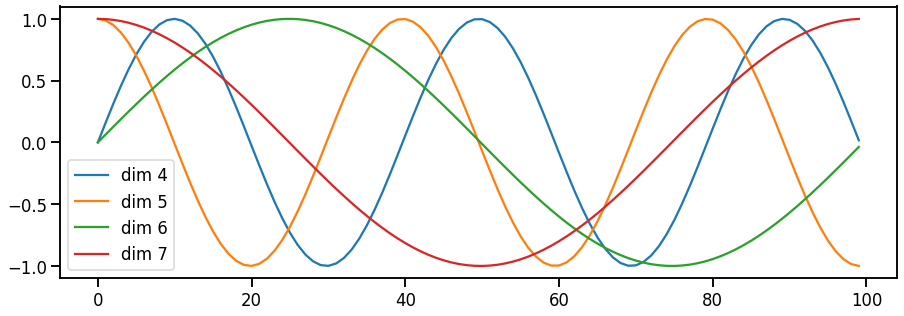

In [19]:
#dimension별 position decoding 출력
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

# **Full Model**

In [20]:
#모델 make__

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    # 파라미터 초기화
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

# **Training**

# **Training Data and Batching**

In [21]:
# 훈련 도중에 마스크가 있는 데이터의 배치를 보관하는 객체라고 볼 수 있다.
# 즉, batch는 곧 마스크를 구성하고 있다고 볼 수 있다.
# source, target sentence, batch 정의.
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        # padding과 미래의 단어(아마 다음 번에 오는 단어 같다)를 숨기기 위해 mask를 만든다.
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)


In [23]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
  # 배치를 계속 늘리고 토큰 + padding의 총 개수를 계산한다.
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    # target의 경우 각각 문장의 끝을 알려주는 eos가 들어가서 2가 더해지는 것 같다.
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

# **Training Loop**

In [22]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    # https://nlp.seas.harvard.edu/2018/04/03/attention.html 의 run_epoch 에 L42을 추가한 버전.
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    #pad_index = SRC.vocab[SRC.pad_token] # <pad> 를 index 인 1 로 변환시키기.

    for i, batch_without_mask in enumerate(data_iter):
        # mask 적용하기.
        batch = Batch(batch_without_mask.src, batch_without_mask.trg, pad_index) # torchtext를 사용해서 이미 iterator가 선언되어버림. 그래서 여기서 마스크를 적용해준다.

        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

# **Optimizer**

In [24]:
#Adam 옵티마이저 사용
class NoamOpt: #noam optimizer
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #옵티마이저에 스텝함수 적용시킴(?)
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    #return값 아담 적용시켜서 보냄

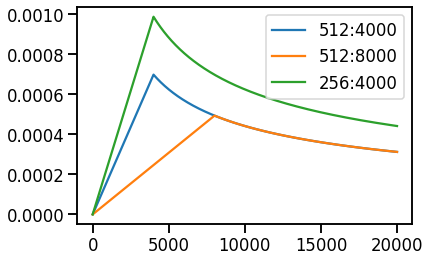

In [25]:
#NoamOpt 입력값은 (model size, factor, trainingsteps, None) 이다.

opts = [NoamOpt(512, 1, 4000, None), #모델사이즈 512, factor 1, warmup 4000, 옵티마이저 None
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]

plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

# **Regularization - Label Smoothing**

In [26]:
#KL div loss를 이용한 label smoothing
#https://3months.tistory.com/465

#레이블 스무딩이란 Szegedy et al. (2016)이 제안한 기법으로 
#말 그대로 레이블을 깎아서(스무딩) 모델 일반화 성능을 꾀합니다. 
#hard target(one-hot-representation)을 soft target으로 바꾸는 것이 핵심입니다.
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


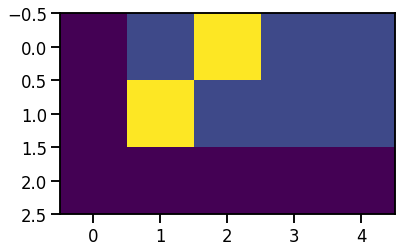

In [27]:
# Example of label smoothing.
# Label smoothing 예시
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


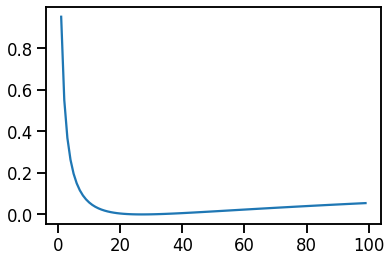

In [28]:
#해결된 오류. data[0] -> data 로 체인지

crit = LabelSmoothing(5, 0, 0.1)
#로스
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 #Variable(torch.LongTensor([1]))).data[0]
                 Variable(torch.LongTensor([1]))).data
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# **Synthetic Data**

In [29]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    #랜덤 데이터 만들기...
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

# **Loss Computation**

In [30]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data * norm

# **Greedy Decoding**

In [31]:
def greedy_decode(model, src, src_mask, max_len, start_symbol): #각각의 step에서 가장 확률이 높은 단어를 decoding.
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

#model.eval()
#src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
#src_mask = Variable(torch.ones(1, 1, 10) )
#print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

# **A Real World Example**

# **Data Loading**

In [32]:
!pip install spacy
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 18.4MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=c648ca260ab3089479c1530b9c6ca8896f0c4ed2a0f85c48187a614bfe380f2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-11181_lo/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [33]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, interleave_keys

def itos(field, batch):
    """
    spaCy는 detokenizing이 불가능한 구조 입니다.
    production, 본격적인 논문 구현을 하실 경우, huggingface tokenizer나 google sentencepiece를 사용하셔야합니다.
    이번 프로젝트에서는 detokenizing을 하지 않고, token의 값만 확인해봅시다.
    """
    with torch.cuda.device_of(batch):
        batch = batch.T.tolist()
    batch = [[field.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

    def trim(s, t):
        sentence = []
        for w in s:
            if w == t:
                break
            sentence.append(w)
        return sentence

    batch = [trim(ex, field.eos_token) for ex in batch]  # trim past frst eos

    def filter_special(tok):
        return tok not in (field.init_token, field.pad_token)

    batch = [list(filter(filter_special, ex)) for ex in batch]
    return batch

SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

# Field, build vocab, batch 로직이 궁금하다면, 아래 레퍼런스를 확인하시면 됩니다.
# Field: https://pytorch.org/text/stable/_modules/torchtext/data/field.html
# Tokenizer 선택 과정: https://pytorch.org/text/_modules/torchtext/data/utils.html
# Batch: https://pytorch.org/text/stable/_modules/torchtext/data/batch.html
# Iterator: https://pytorch.org/text/stable/_modules/torchtext/data/iterator.html#Iterator

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 967kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 278kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 264kB/s]
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [34]:
# special token 확인하기
(
    'SRC',
    SRC.init_token, SRC.eos_token, SRC.pad_token,
    'TRG',
    TRG.init_token, TRG.eos_token, TRG.pad_token,
)

('SRC', '<sos>', '<eos>', '<pad>', 'TRG', '<sos>', '<eos>', '<pad>')

In [35]:
#임의로 단어를 만들어 준다
SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

In [36]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# **Check the Data**

In [59]:
# 데이터 확인해보기.
pad_index = SRC.vocab[SRC.pad_token]
for batch_without_mask in train_iterator:
    batch = Batch(batch_without_mask.src, batch_without_mask.trg, pad_index)
    print(batch.src.shape, batch.src_mask.shape, batch.trg.shape, batch.trg_mask.shape)
    print(batch.src, batch.src_mask, batch.trg, batch.trg_mask)
    print(itos(SRC, batch.src))
    print(itos(TRG, batch.trg))

    break

torch.Size([31, 128]) torch.Size([31, 1, 128]) torch.Size([35, 127]) torch.Size([35, 127, 127])
tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  5,  18,   5,  ...,   5,   5,   8],
        [ 13,  80,  13,  ...,  26,  13, 364],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0') tensor([[[ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True]],

        ...,

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]]], device='cuda:0') tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  4,  16,   4,  ...,   4,   4,   4],
        [  9, 127,   9,  ...,  64,  34,   9],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
   

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# **Training the Model**

In [38]:
# https://nlp.seas.harvard.edu/2018/04/03/attention.html 의 모델을 구현하고, FULL Model 부분의 make_model 을 통해서 모델을 생성해주시면 됩니다.
model = make_model(len(SRC.vocab), len(TRG.vocab), N=6)
model.to(device)

pad_idx = TRG.vocab.stoi["<pad>"]
criterion = LabelSmoothing(len(TRG.vocab), pad_idx, 0.1)
criterion.to(device)

model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
torch.cuda.empty_cache()

for epoch in range(10):
    print(epoch)
    model.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iterator), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch((rebatch(pad_idx, b) for b in valid_iterator), model, 
                    SimpleLossCompute(model.generator, criterion, None)))
    print(loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


0
Epoch Step: 1 Loss: 7.970439 Tokens per Sec: 3648.469238
Epoch Step: 51 Loss: 6.647731 Tokens per Sec: 4378.949219
Epoch Step: 101 Loss: 5.408745 Tokens per Sec: 4306.833008
Epoch Step: 151 Loss: 4.496586 Tokens per Sec: 4176.561523
Epoch Step: 201 Loss: 4.096111 Tokens per Sec: 4123.807617
Epoch Step: 1 Loss: 3.751302 Tokens per Sec: 7420.284668
tensor(3.9087, device='cuda:0')
<function loss at 0x7f1f7a77e8c8>
1
Epoch Step: 1 Loss: 4.169782 Tokens per Sec: 3818.850342
Epoch Step: 51 Loss: 3.709027 Tokens per Sec: 4092.589600
Epoch Step: 101 Loss: 3.393698 Tokens per Sec: 4051.317383
Epoch Step: 151 Loss: 3.248222 Tokens per Sec: 3982.982666
Epoch Step: 201 Loss: 3.143973 Tokens per Sec: 3910.019531
Epoch Step: 1 Loss: 2.711947 Tokens per Sec: 7122.071777
tensor(2.8899, device='cuda:0')
<function loss at 0x7f1f7a77e8c8>
2
Epoch Step: 1 Loss: 3.230593 Tokens per Sec: 3508.056885
Epoch Step: 51 Loss: 2.691607 Tokens per Sec: 3900.503662
Epoch Step: 101 Loss: 2.732656 Tokens per Sec: 38

# **Evaluate the Model**

In [53]:
for i, batch in enumerate(valid_iterator) :
  src = batch.src.transpose(0, 1)[: 1]
  src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)
  out = greedy_decode(model, src, src_mask, max_len = 60, start_symbol= TRG.vocab.stoi["<sos>"])
  print("Translation:", end="\t")

  for i in range(1, out.size(1)): 
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "<eos>": break
    print(sym, end = " ")
  print("\n")
  print("Target : ", end = '\t')
  
  for i in range(1, batch.trg.size(0)) : 
    sym = TRG.vocab.itos[batch.trg.data[i, 0]]
    if sym == "<eos>": break
    print(sym, end = " ")
  print('\n\n')

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Translation:	a man cooking on a black grill . 

Target : 	a man cooking burgers on a black grill . 


Translation:	people protest " <unk> <unk> on the <unk> car <unk> car . 

Target : 	people protesting age <unk> in an organized street rally . 


Translation:	a young boy in black is hitting a wheel on the beach . 

Target : 	a boy in black clothes is doing a cartwheel on the beach . 


Translation:	a boy stands on <unk> car that is gathered around an outdoor social gathering . 

Target : 	a boy stands <unk> in the middle of a social gathering . 


Translation:	a man is standing holding a microphone in front of a man with a guitar . 

Target : 	a standing man holds a microphone in front of a man holding a guitar . 


Translation:	a man in a red hoodie and a white apron is standing in front of a mural . 

Target : 	a man in a red hoodie with a white apron stands in front of a mural . 


Translation:	a person in a purple top is painting a picture of a woman on a white wall . 

Target : 	a

In [71]:
model.eval()
sent = "Ein blondes Mädchen sitzt auf einem Stuhl und beobachtet die Kinder im Park.".lower().split()

src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]]).to(device)
src = Variable(src)
print(src)
src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, max_len=60, start_symbol=TRG.vocab.stoi["<sos>"])
print("Translation:", end="\t")
trans = "<sos>"

for i in range(1, out.size(1)): 
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "<eos>": break
    trans += sym + " "
print(trans)


tensor([[  5, 385,  25,  31,  12,   6, 268,  10, 290,  17,  65,  20,   0]],
       device='cuda:0')
Translation:	<sos>a blond girl is sitting on a chair watching the children 's <unk> in the " <unk> . 


# **Attention Visualization**

Encoder Layer 2


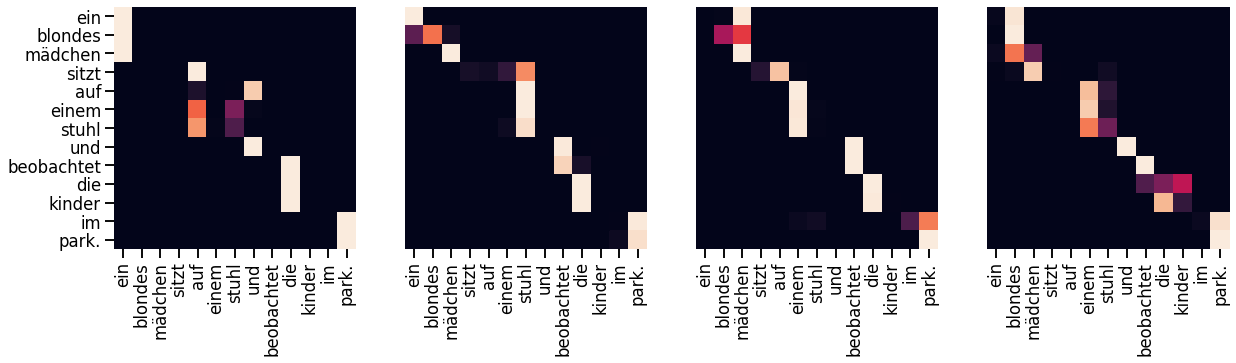

Encoder Layer 4


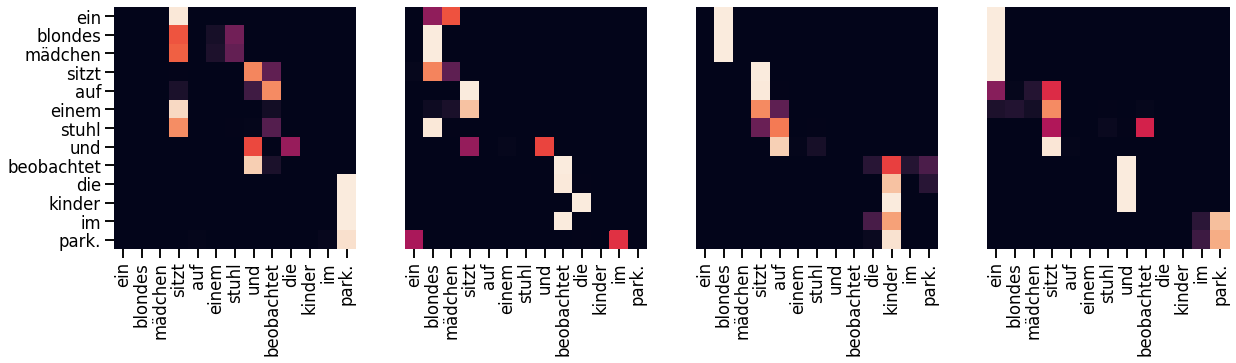

Encoder Layer 6


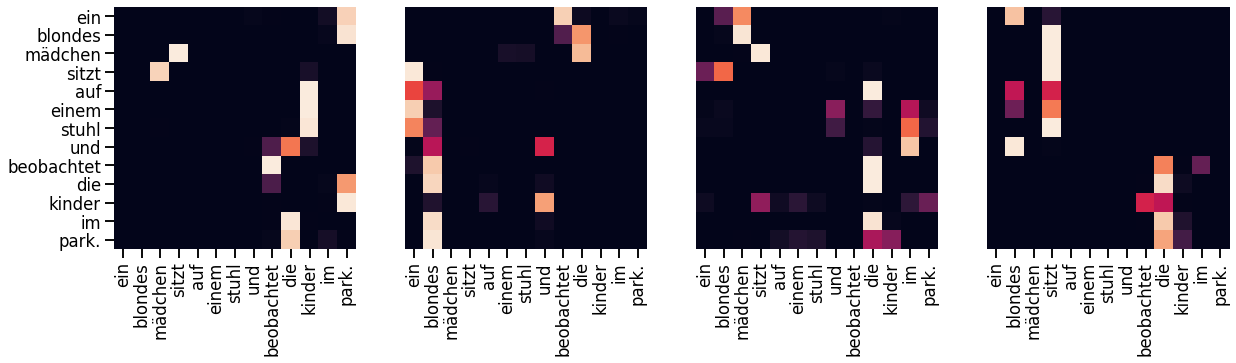

Decoder Self Layer 2


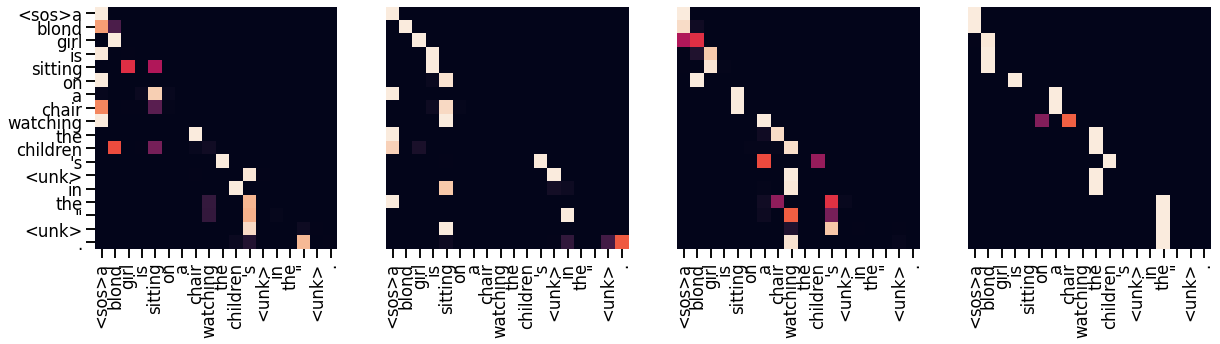

Decoder Src Layer 2


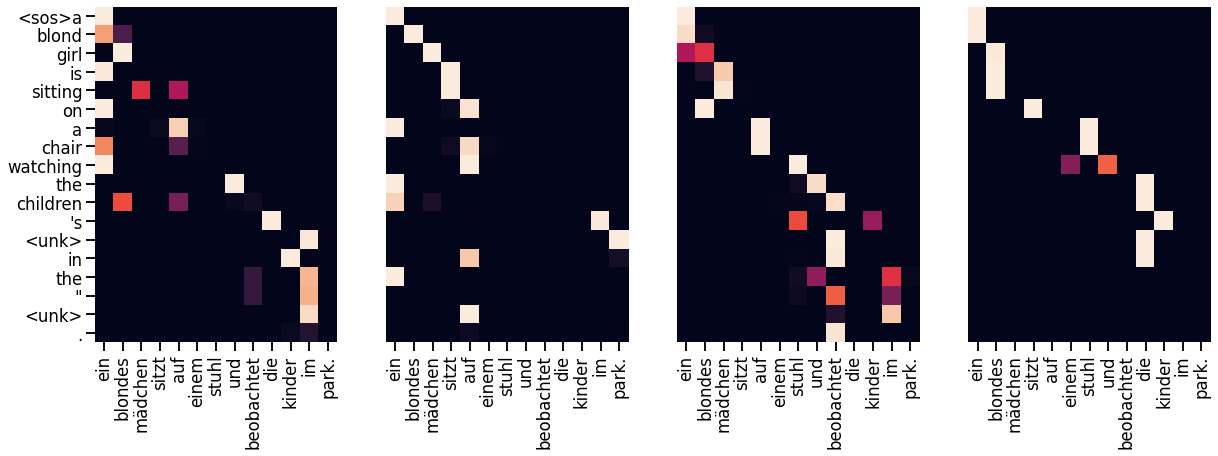

Decoder Self Layer 4


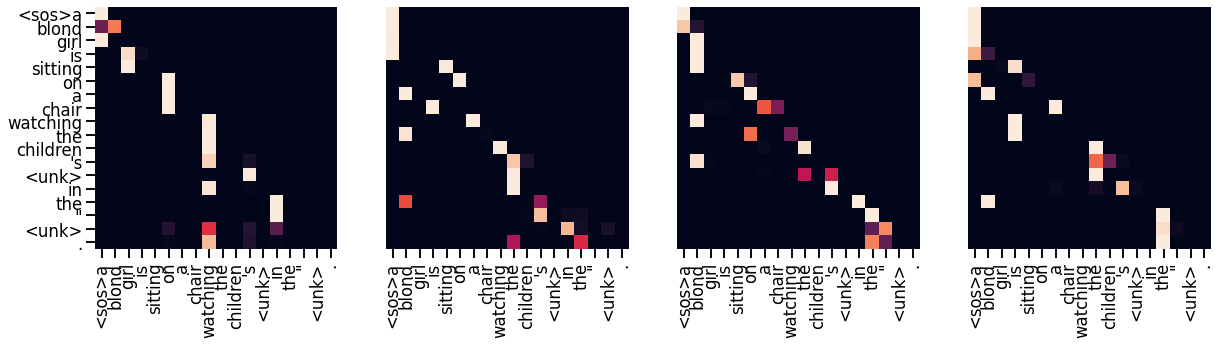

Decoder Src Layer 4


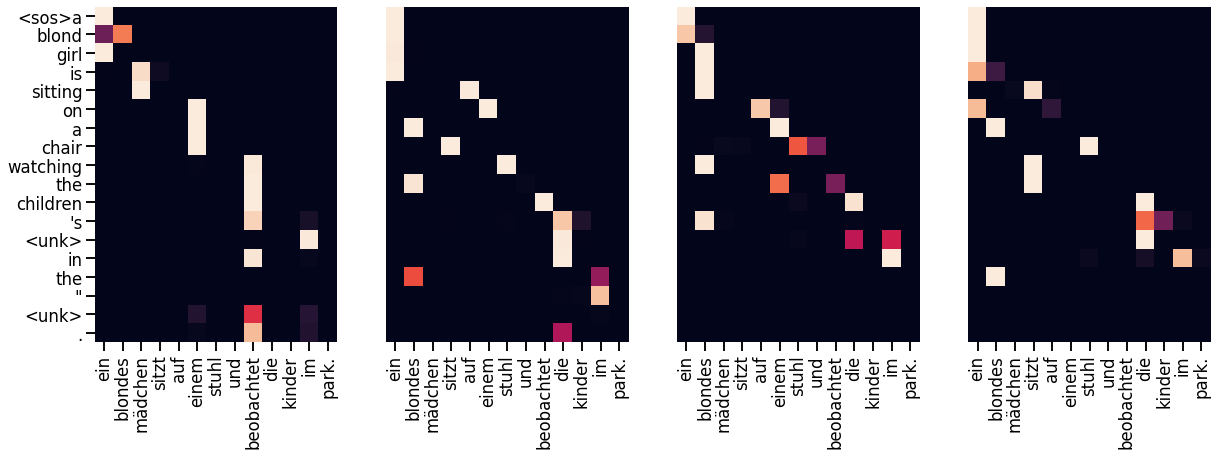

Decoder Self Layer 6


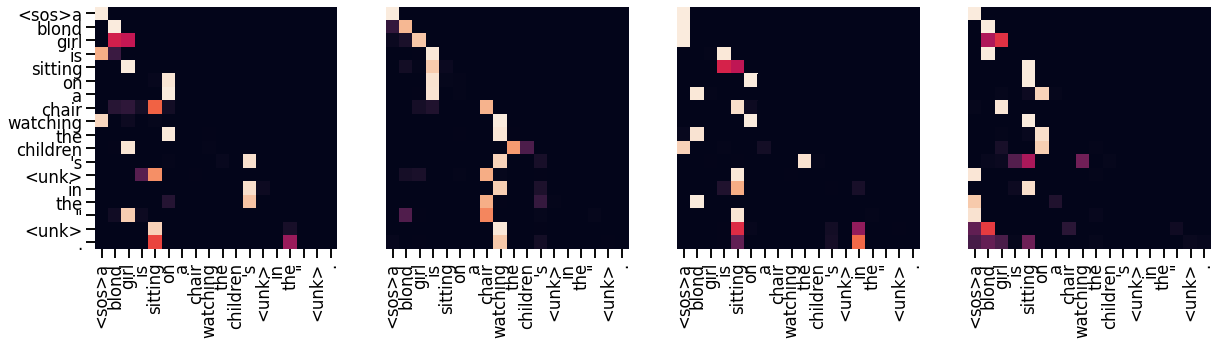

Decoder Src Layer 6


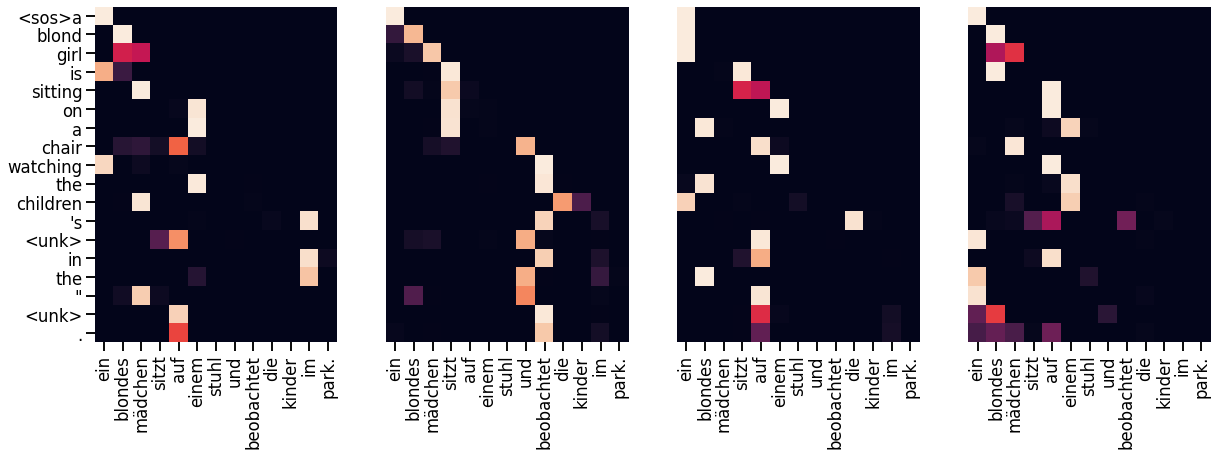

In [72]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data.cpu(), 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()